In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from pandas import Grouper
from pandas import DataFrame

from numpy import sqrt
from numpy import log

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf 

from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot

from statsmodels.tsa.stattools import adfuller

In [2]:
data = pd.read_csv('DCOILBRENTEU.csv')

In [3]:
data.shape

(9524, 2)

In [4]:
data.head()

,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [5]:
data = data.rename(columns={'DATE': 'date', 'DCOILBRENTEU': 'DCOILBRENTEU'})

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9524 entries, 0 to 9523
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          9524 non-null   object
 1   DCOILBRENTEU  9524 non-null   object
dtypes: object(2)
memory usage: 148.9+ KB


In [7]:
data.isnull().sum()

date            0
DCOILBRENTEU    0
dtype: int64

In [8]:
df = data.copy()

In [9]:
df[df.duplicated()]

,date,DCOILBRENTEU


In [10]:
data['date']

0       1987-05-20
1       1987-05-21
2       1987-05-22
3       1987-05-25
4       1987-05-26
           ...    
9519    2023-11-14
9520    2023-11-15
9521    2023-11-16
9522    2023-11-17
9523    2023-11-20
Name: date, Length: 9524, dtype: object

In [11]:
df.replace('.', pd.NA, inplace=True)

In [12]:
df.isnull().sum()

date              0
DCOILBRENTEU    259
dtype: int64

In [13]:
df['DCOILBRENTEU'] = pd.to_numeric(df['DCOILBRENTEU'], errors='coerce')

In [14]:
df['date'] = pd.to_datetime(df['date'])

In [15]:
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month

In [16]:
# mean of 'DCOILBRENTEU' for each month, grouped by year and month

mean_values = df.groupby(['Year', 'Month'])['DCOILBRENTEU'].mean()

In [17]:
def fill_missing(row):
    if pd.isnull(row['DCOILBRENTEU']):
        year = row['Year']
        month = row['Month']
        return mean_values[year][month]
    return row['DCOILBRENTEU']

In [18]:
df['DCOILBRENTEU'] = df.apply(fill_missing, axis=1)

In [19]:
df.drop(['Year', 'Month'], axis=1, inplace=True)

In [20]:
df['DCOILBRENTEU'] = df['DCOILBRENTEU'].round(2)

# Visualization

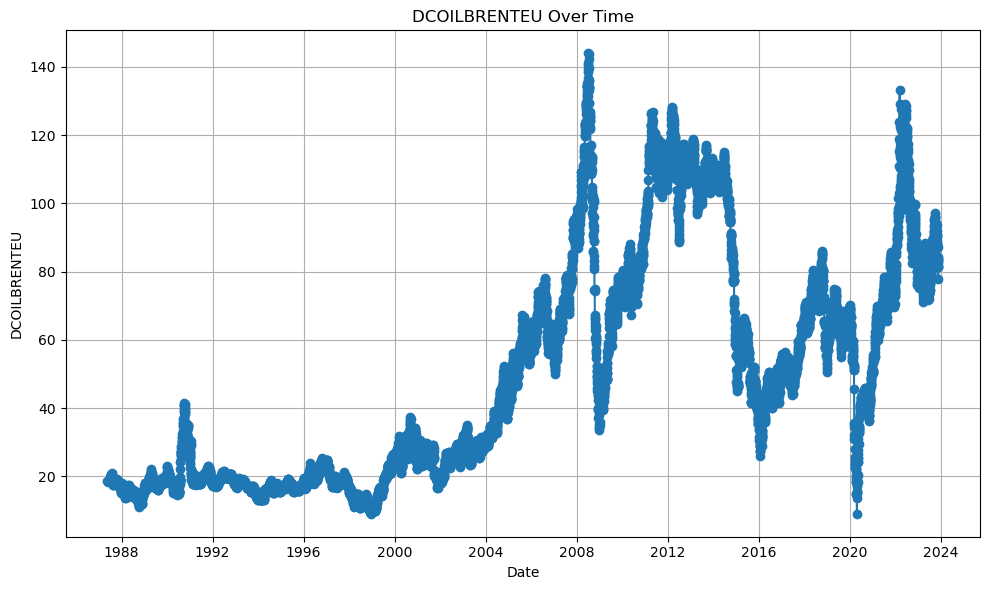

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['DCOILBRENTEU'], marker='o', linestyle='-')
plt.title('DCOILBRENTEU Over Time')
plt.xlabel('Date')
plt.ylabel('DCOILBRENTEU')
plt.grid(True)
plt.tight_layout()
plt.show()

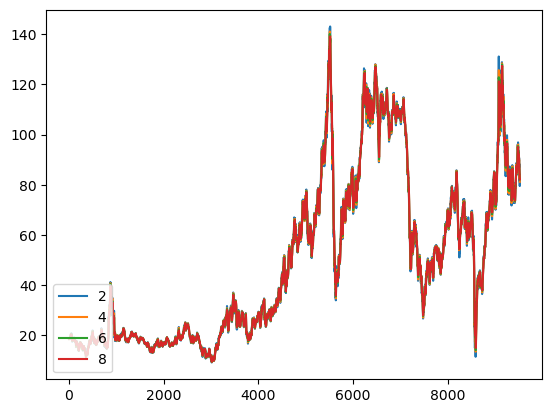

In [22]:
for i in range(2,10,2):
    df["DCOILBRENTEU"].rolling(i).mean().plot(label = str(i))
plt.legend(loc=3)

/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_1458/3288014032.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['DCOILBRENTEU'], shade=True)


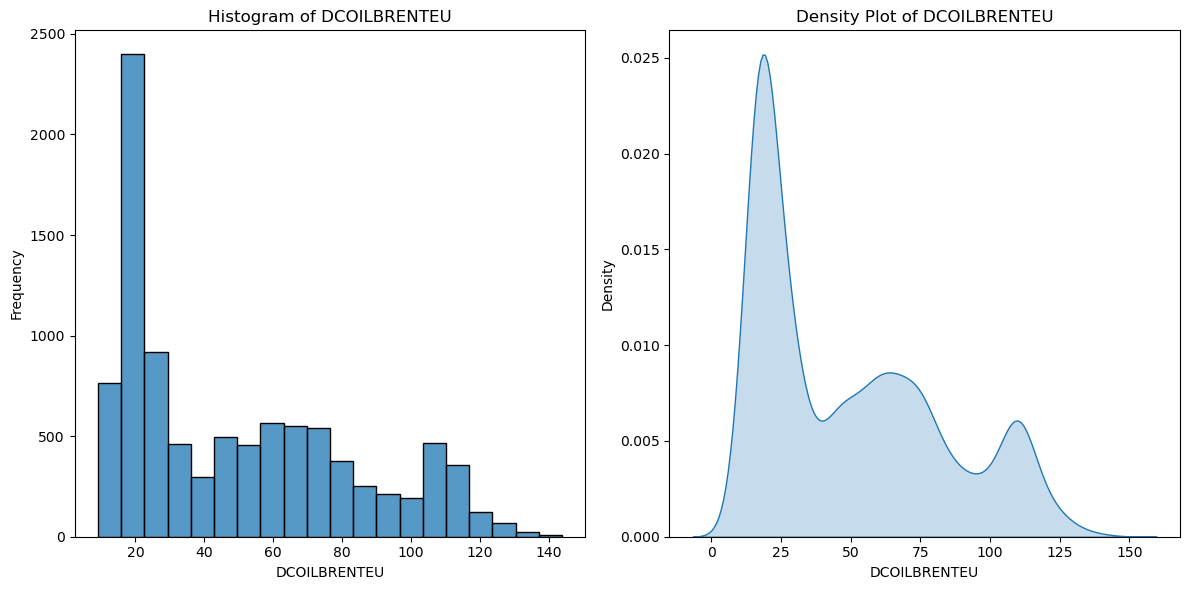

In [23]:
# Creating subplots for histogram and density plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Histogram
sns.histplot(df['DCOILBRENTEU'], bins=20, kde=False)
plt.title('Histogram of DCOILBRENTEU')
plt.xlabel('DCOILBRENTEU')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)  # Density plot
sns.kdeplot(df['DCOILBRENTEU'], shade=True)
plt.title('Density Plot of DCOILBRENTEU')
plt.xlabel('DCOILBRENTEU')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

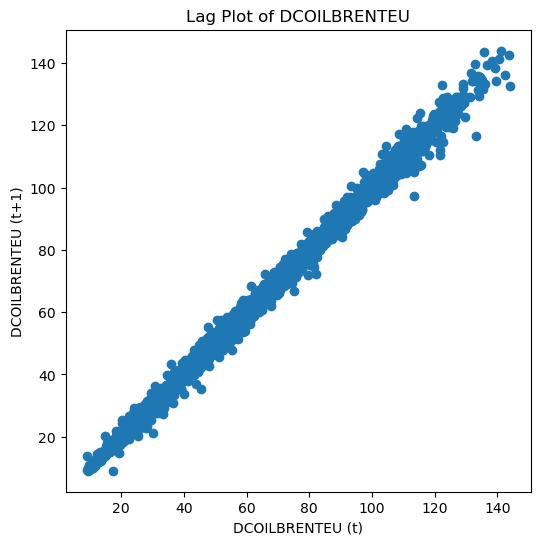

In [24]:
# Creating a lag plot
plt.figure(figsize=(6, 6))
lag_plot(df['DCOILBRENTEU'])
plt.title('Lag Plot of DCOILBRENTEU')
plt.xlabel('DCOILBRENTEU (t)')
plt.ylabel('DCOILBRENTEU (t+1)')
plt.show()

<Figure size 1000x600 with 0 Axes>

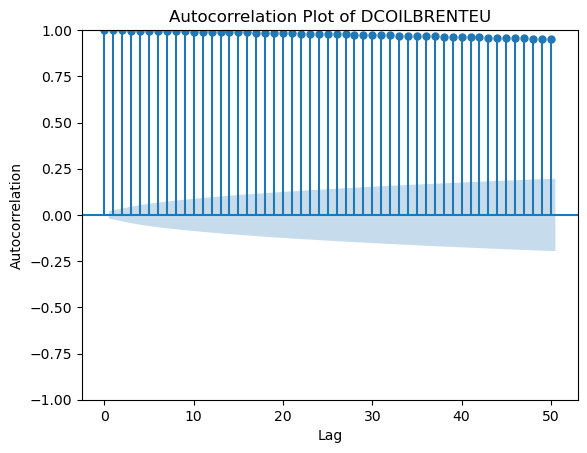

In [25]:
# Creating an autocorrelation plot
plt.figure(figsize=(10, 6))
plot_acf(df['DCOILBRENTEU'], lags=50)  # Adjust the number of lags as needed
plt.title('Autocorrelation Plot of DCOILBRENTEU')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# checking for data stationarity

In [26]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [27]:
# Perform ADF test
result = adfuller(df['DCOILBRENTEU'])

In [28]:
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -2.116525385914011
p-value: 0.23792178843646417
Critical Values:
	1%: -3.431039477205773
	5%: -2.8618447060967434
	10%: -2.566932189953556


The p-value resulting from the Augmented Dickey-Fuller (ADF) test is 0.2379. When comparing this to common significance levels like 0.05, the p-value is higher, indicating that there isn't enough evidence to reject the null hypothesis.

This suggests that the data might not be stationary. In non-stationary data, you typically see trends, seasonality, or other patterns that affect the mean or variance across time. You might consider further analysis or transformations to make the data stationary if needed for time series modeling or analysis.

# using differentation for making the data stationary

In [29]:
# Differencing to make the series stationary
df['Stationary_Value'] = df['DCOILBRENTEU'].diff()

In [30]:
# Dropping NaN resulting from differencing (first value becomes NaN)
df.dropna(inplace=True)

print(df)

            DCOILBRENTEU  Stationary_Value
date                                      
1987-05-21         18.45             -0.18
1987-05-22         18.55              0.10
1987-05-25         18.60              0.05
1987-05-26         18.63              0.03
1987-05-27         18.60             -0.03
...                  ...               ...
2023-11-14         84.20              0.11
2023-11-15         82.40             -1.80
2023-11-16         77.73             -4.67
2023-11-17         81.22              3.49
2023-11-20         83.25              2.03

[9523 rows x 2 columns]


# using log for making the data stationary

In [31]:
# Applying a logarithmic transformation
df['Log_Value'] = df['DCOILBRENTEU'].apply(lambda x: 0 if x == 0 else np.log(x))

In [32]:
# Dropping NaN resulting from differencing (first value becomes NaN)
df.dropna(inplace=True)

print(df)

            DCOILBRENTEU  Stationary_Value  Log_Value
date                                                 
1987-05-21         18.45             -0.18   2.915064
1987-05-22         18.55              0.10   2.920470
1987-05-25         18.60              0.05   2.923162
1987-05-26         18.63              0.03   2.924773
1987-05-27         18.60             -0.03   2.923162
...                  ...               ...        ...
2023-11-14         84.20              0.11   4.433195
2023-11-15         82.40             -1.80   4.411585
2023-11-16         77.73             -4.67   4.353241
2023-11-17         81.22              3.49   4.397162
2023-11-20         83.25              2.03   4.421848

[9523 rows x 3 columns]


In [33]:
# Reset the index to convert the 'date' index into a column
df_reset = df.reset_index()

# Create a new DataFrame with 'DATE' and 'Log_Value' columns
new_df = df_reset[['date', 'Log_Value']].copy()

print(new_df)

           date  Log_Value
0    1987-05-21   2.915064
1    1987-05-22   2.920470
2    1987-05-25   2.923162
3    1987-05-26   2.924773
4    1987-05-27   2.923162
...         ...        ...
9518 2023-11-14   4.433195
9519 2023-11-15   4.411585
9520 2023-11-16   4.353241
9521 2023-11-17   4.397162
9522 2023-11-20   4.421848

[9523 rows x 2 columns]


In [34]:
new_df

,date,Log_Value
0,1987-05-21,2.915064
1,1987-05-22,2.920470
2,1987-05-25,2.923162
3,1987-05-26,2.924773
4,1987-05-27,2.923162
...,...,...
9518,2023-11-14,4.433195
9519,2023-11-15,4.411585
9520,2023-11-16,4.353241
9521,2023-11-17,4.397162


# upsampling

In [35]:
new_df.set_index('date', inplace=True)

In [36]:
print(new_df.columns)

Index(['Log_Value'], dtype='object')


In [37]:
upsampled = new_df.resample('D').ffill()

In [38]:
print(upsampled)

            Log_Value
date                 
1987-05-21   2.915064
1987-05-22   2.920470
1987-05-23   2.920470
1987-05-24   2.920470
1987-05-25   2.923162
...               ...
2023-11-16   4.353241
2023-11-17   4.397162
2023-11-18   4.397162
2023-11-19   4.397162
2023-11-20   4.421848

[13333 rows x 1 columns]


            Log_Value
date                 
1987-05-21   2.915064
1987-05-22   2.920470
1987-05-23   2.920470
1987-05-24   2.920470
1987-05-25   2.923162
1987-05-26   2.924773
1987-05-27   2.923162
1987-05-28   2.923162
1987-05-29   2.922086
1987-05-30   2.922086
1987-05-31   2.922086
1987-06-01   2.925846
1987-06-02   2.927453
1987-06-03   2.931194
1987-06-04   2.932792


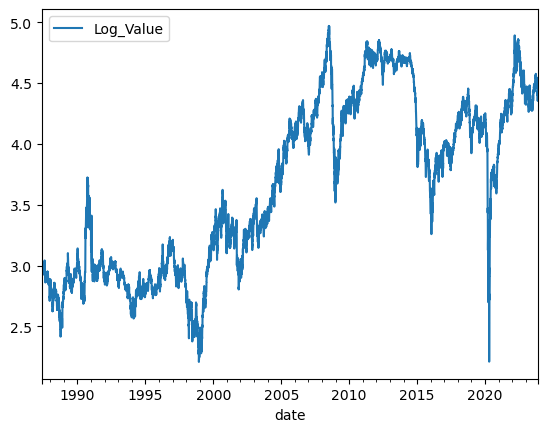

In [39]:
interpolated = upsampled.interpolate(method = 'linear')
## interplation was done for nan values which we get after doing upsampling by month
print(interpolated.head(15))
interpolated.plot()
plt.show()

# Time Series Decomposition

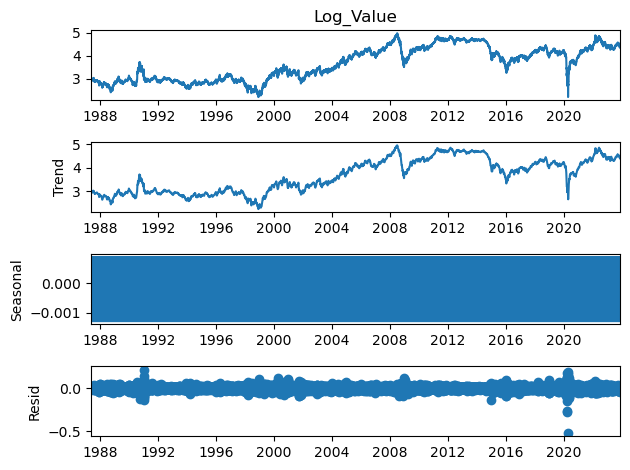

In [40]:
decompose_ts_add = seasonal_decompose(interpolated.Log_Value)  
decompose_ts_add.plot()
plt.show()

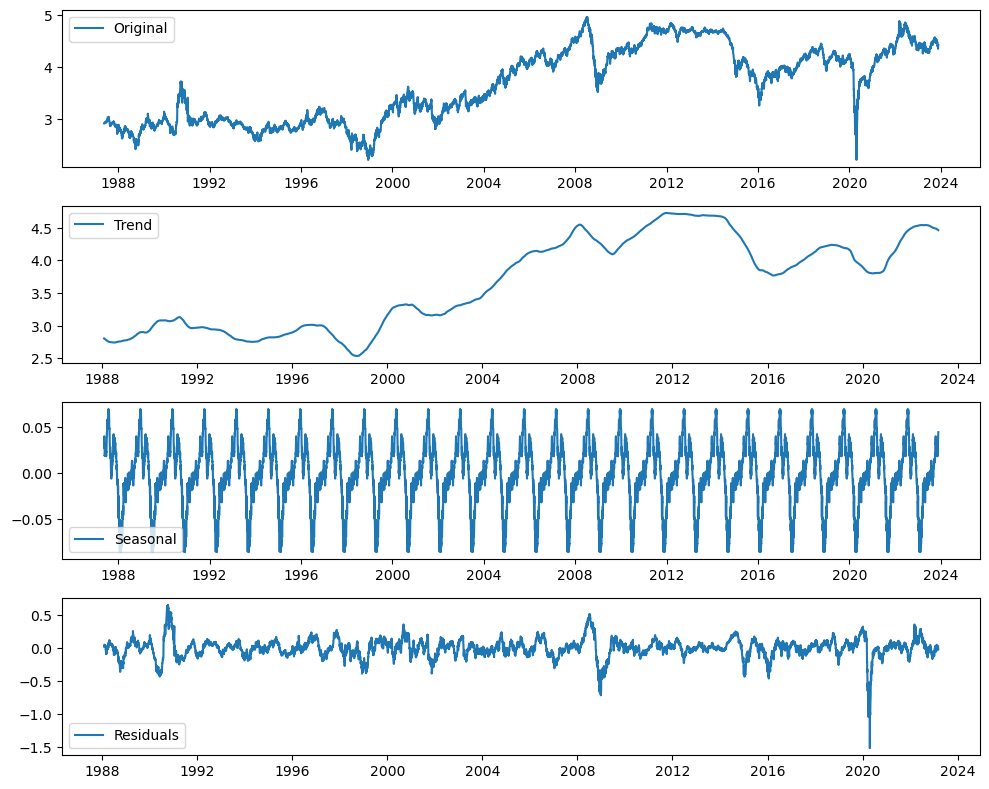

In [41]:
result = seasonal_decompose(new_df['Log_Value'], model='additive', period=365)  # Assuming yearly seasonality

# Plot the decomposition
plt.figure(figsize=(10, 8))

plt.subplot(411)
plt.plot(result.observed, label='Original')
plt.legend()

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(result.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

# ACF plots and PACF plots 

/Users/kishore/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


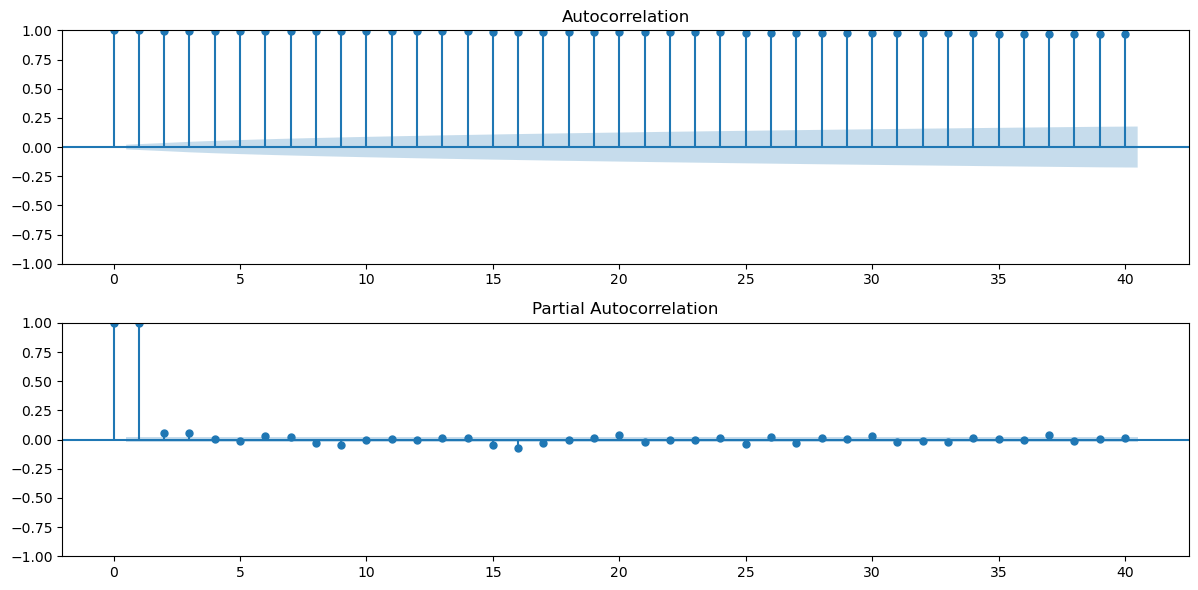

In [42]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(211)
plot_acf(new_df['Log_Value'], lags=40, ax=plt.gca())  # Adjust the number of lags as needed

# PACF plot
plt.subplot(212)
plot_pacf(new_df['Log_Value'], lags=40, ax=plt.gca())  # Adjust the number of lags as needed

plt.tight_layout()
plt.show()

# evaluation metric MAPE(mean Absolute percentage Error)

In [43]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

# Simple Exponential Method

In [44]:
model = SimpleExpSmoothing(new_df['Log_Value'])
fit_model = model.fit()

# Forecast for the next 10 periods (adjust as needed)
forecast = fit_model.forecast(steps=10)

print("Forecasted values using Simple Exponential Smoothing:")
print(forecast)

Forecasted values using Simple Exponential Smoothing:
2023-11-21    4.420198
2023-11-22    4.420198
2023-11-23    4.420198
2023-11-24    4.420198
2023-11-27    4.420198
2023-11-28    4.420198
2023-11-29    4.420198
2023-11-30    4.420198
2023-12-01    4.420198
2023-12-04    4.420198
Freq: B, dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


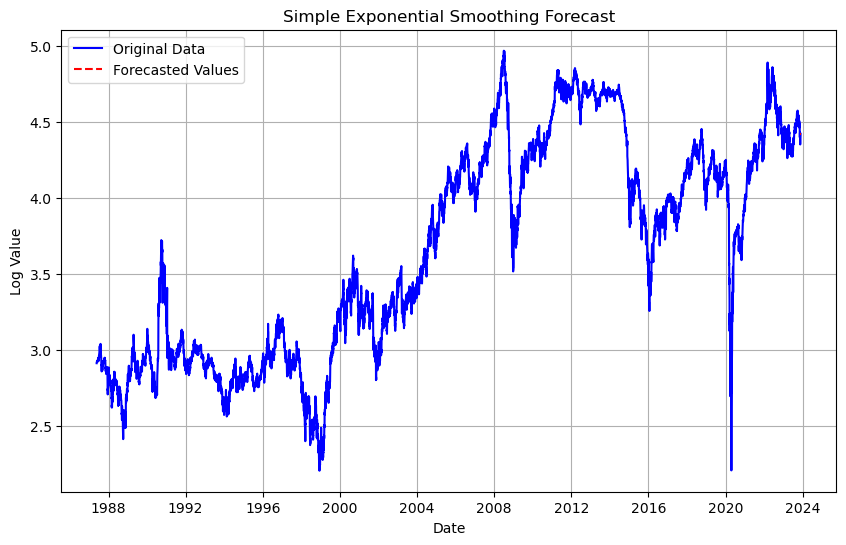

In [45]:
# Plotting original data
plt.figure(figsize=(10, 6))
plt.plot(new_df.index, new_df['Log_Value'], label='Original Data', color='blue')

# Plotting forecasted values
forecast_dates = pd.date_range(start=new_df.index[-1], periods=11, freq='B')[1:]  # Generating dates for forecast
plt.plot(forecast_dates, forecast, label='Forecasted Values', color='red', linestyle='--')

plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Log Value')
plt.legend()
plt.grid(True)
plt.show()

# Holt method

In [46]:
# Fit Holt's Exponential Smoothing
model = ExponentialSmoothing(new_df['Log_Value'], trend='add')
fit_model = model.fit()

# Forecast for the next 10 periods (adjust as needed)
forecast = fit_model.forecast(steps=10)

print("Forecasted values using Holt's Exponential Smoothing:")
print(forecast)

Forecasted values using Holt's Exponential Smoothing:
2023-11-21    4.420368
2023-11-22    4.420528
2023-11-23    4.420688
2023-11-24    4.420848
2023-11-27    4.421008
2023-11-28    4.421168
2023-11-29    4.421328
2023-11-30    4.421488
2023-12-01    4.421648
2023-12-04    4.421808
Freq: B, dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


# Holts winter exponential smoothing with additive seasonality and additive trend

In [47]:
# Fit Holt-Winters' Exponential Smoothing with additive seasonality and trend
model = ExponentialSmoothing(new_df['Log_Value'], trend='add', seasonal='add', seasonal_periods=12)  # Assuming monthly seasonality
fit_model = model.fit()

# Forecast for the next 10 periods (adjust as needed)
forecast = fit_model.forecast(steps=10)

print("Forecasted values using Holt-Winters' Exponential Smoothing with additive seasonality and trend:")
print(forecast)

/Users/kishore/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


Forecasted values using Holt-Winters' Exponential Smoothing with additive seasonality and trend:
2023-11-21    4.421646
2023-11-22    4.420766
2023-11-23    4.422183
2023-11-24    4.422357
2023-11-27    4.422393
2023-11-28    4.423030
2023-11-29    4.422527
2023-11-30    4.422479
2023-12-01    4.423780
2023-12-04    4.423825
Freq: B, dtype: float64


# Holts winter exponential smoothing with mutliplicative seasonality and additive trend

In [48]:
# Fit Holt-Winters' Exponential Smoothing with multiplicative seasonality and additive trend
model = ExponentialSmoothing(new_df['Log_Value'], trend='add', seasonal='mul', seasonal_periods=12)  # Assuming monthly seasonality
fit_model = model.fit()

# Forecast for the next 10 periods (adjust as needed)
forecast = fit_model.forecast(steps=10)

print("Forecasted values using Holt-Winters' Exponential Smoothing with multiplicative seasonality and additive trend:")
print(forecast)

/Users/kishore/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


Forecasted values using Holt-Winters' Exponential Smoothing with multiplicative seasonality and additive trend:
2023-11-21    4.421647
2023-11-22    4.420918
2023-11-23    4.422552
2023-11-24    4.422537
2023-11-27    4.422831
2023-11-28    4.423795
2023-11-29    4.423010
2023-11-30    4.422776
2023-12-01    4.424419
2023-12-04    4.424299
Freq: B, dtype: float64


In [49]:
interpolated

,Log_Value
date,
1987-05-21,2.915064
1987-05-22,2.920470
1987-05-23,2.920470
1987-05-24,2.920470
1987-05-25,2.923162
...,...
2023-11-16,4.353241
2023-11-17,4.397162
2023-11-18,4.397162


In [50]:
interpolated.reset_index(inplace = True)

In [51]:
interpolated['t'] = 1

In [52]:
interpolated

,date,Log_Value,t
0,1987-05-21,2.915064,1
1,1987-05-22,2.920470,1
2,1987-05-23,2.920470,1
3,1987-05-24,2.920470,1
4,1987-05-25,2.923162,1
...,...,...,...
13328,2023-11-16,4.353241,1
13329,2023-11-17,4.397162,1
13330,2023-11-18,4.397162,1
13331,2023-11-19,4.397162,1


In [53]:
for i,row in interpolated.iterrows():
    interpolated['t'].iloc[i] = i+1

/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_1458/431847507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpolated['t'].iloc[i] = i+1


In [54]:
interpolated['t_sq'] = (interpolated['t'])**2

In [55]:
interpolated["month"] = interpolated.date.dt.strftime("%b") # month extraction
interpolated["year"] = interpolated.date.dt.strftime("%Y") # month extraction
interpolated

,date,Log_Value,t,t_sq,month,year
0,1987-05-21,2.915064,1,1,May,1987
1,1987-05-22,2.920470,2,4,May,1987
2,1987-05-23,2.920470,3,9,May,1987
3,1987-05-24,2.920470,4,16,May,1987
4,1987-05-25,2.923162,5,25,May,1987
...,...,...,...,...,...,...
13328,2023-11-16,4.353241,13329,177662241,Nov,2023
13329,2023-11-17,4.397162,13330,177688900,Nov,2023
13330,2023-11-18,4.397162,13331,177715561,Nov,2023
13331,2023-11-19,4.397162,13332,177742224,Nov,2023


In [56]:
months = pd.get_dummies(interpolated['month']) # converting the dummy variables for month column
months

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
13328,0,0,0,0,0,0,0,0,0,1,0,0
13329,0,0,0,0,0,0,0,0,0,1,0,0
13330,0,0,0,0,0,0,0,0,0,1,0,0
13331,0,0,0,0,0,0,0,0,0,1,0,0


In [57]:
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]

In [58]:
pp = pd.concat([interpolated,months],axis=1)
pp.head()

,date,Log_Value,t,t_sq,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1987-05-21,2.915064,1,1,May,1987,0,0,0,0,1,0,0,0,0,0,0,0
1,1987-05-22,2.920470,2,4,May,1987,0,0,0,0,1,0,0,0,0,0,0,0
2,1987-05-23,2.920470,3,9,May,1987,0,0,0,0,1,0,0,0,0,0,0,0
3,1987-05-24,2.920470,4,16,May,1987,0,0,0,0,1,0,0,0,0,0,0,0
4,1987-05-25,2.923162,5,25,May,1987,0,0,0,0,1,0,0,0,0,0,0,0


In [59]:
pp['Log_Value'] = np.log(pp['Log_Value'])
pp

,date,Log_Value,t,t_sq,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1987-05-21,1.069892,1,1,May,1987,0,0,0,0,1,0,0,0,0,0,0,0
1,1987-05-22,1.071744,2,4,May,1987,0,0,0,0,1,0,0,0,0,0,0,0
2,1987-05-23,1.071744,3,9,May,1987,0,0,0,0,1,0,0,0,0,0,0,0
3,1987-05-24,1.071744,4,16,May,1987,0,0,0,0,1,0,0,0,0,0,0,0
4,1987-05-25,1.072666,5,25,May,1987,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13328,2023-11-16,1.470921,13329,177662241,Nov,2023,0,0,0,0,0,0,0,0,0,0,1,0
13329,2023-11-17,1.480959,13330,177688900,Nov,2023,0,0,0,0,0,0,0,0,0,0,1,0
13330,2023-11-18,1.480959,13331,177715561,Nov,2023,0,0,0,0,0,0,0,0,0,0,1,0
13331,2023-11-19,1.480959,13332,177742224,Nov,2023,0,0,0,0,0,0,0,0,0,0,1,0


In [60]:
train1, test1 = np.split(pp, [int(.70 *len(pp))])

In [ ]:
plt.figure(figsize = (100,50))
heatmap_y_month = pd.pivot_table(data = pp,values = "Log_Value",index = "year",columns = "month",aggfunc = "mean",fill_value = 0)
sns.heatmap(heatmap_y_month,annot = True,fmt = "g")

<Axes: xlabel='month', ylabel='year'>

<Axes: xlabel='year', ylabel='Log_Value'>

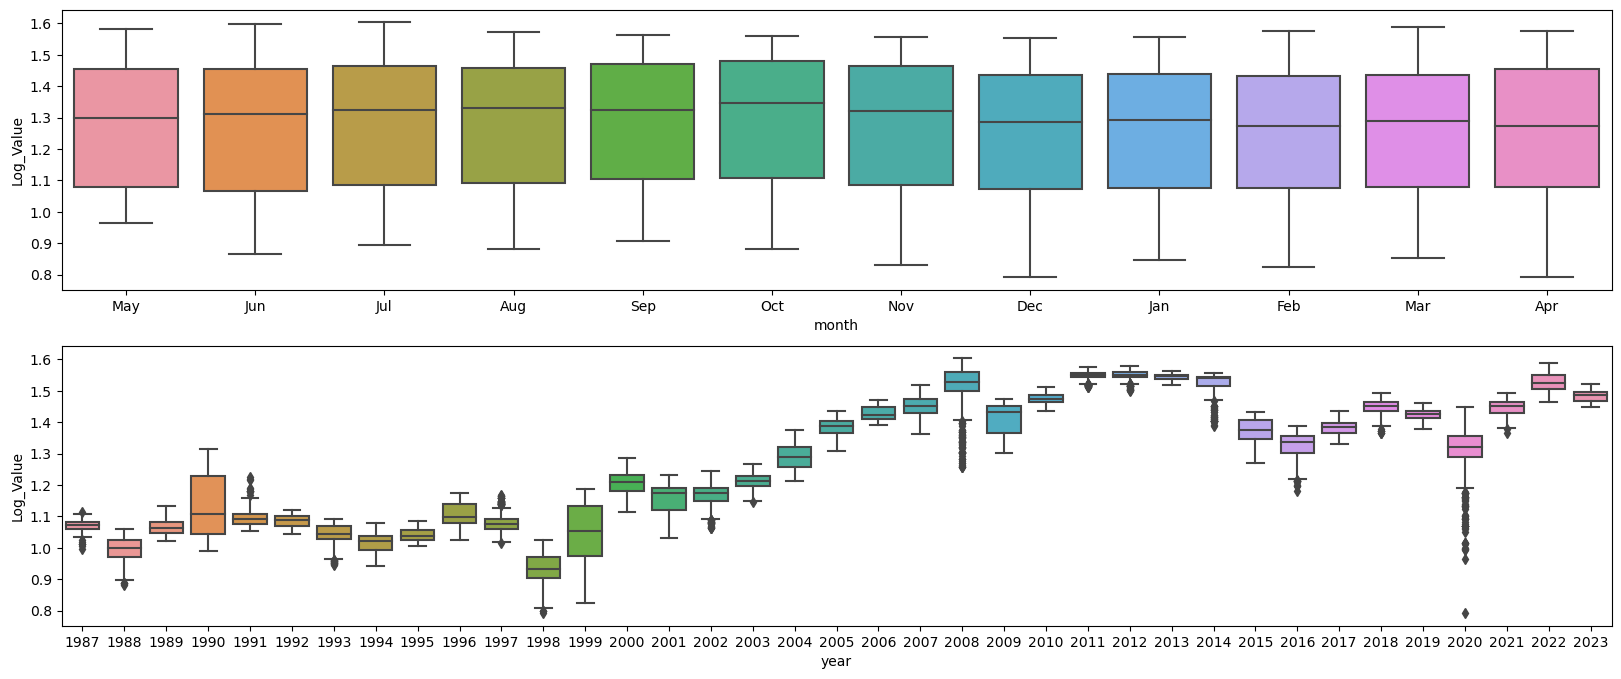

In [62]:
# Boxplot 
plt.figure(figsize = (20,8))
plt.subplot(211)
sns.boxplot(x = "month",y = "Log_Value",data = pp)
plt.subplot(212)
sns.boxplot(x = "year",y = "Log_Value",data = pp)

<Axes: xlabel='year', ylabel='Log_Value'>

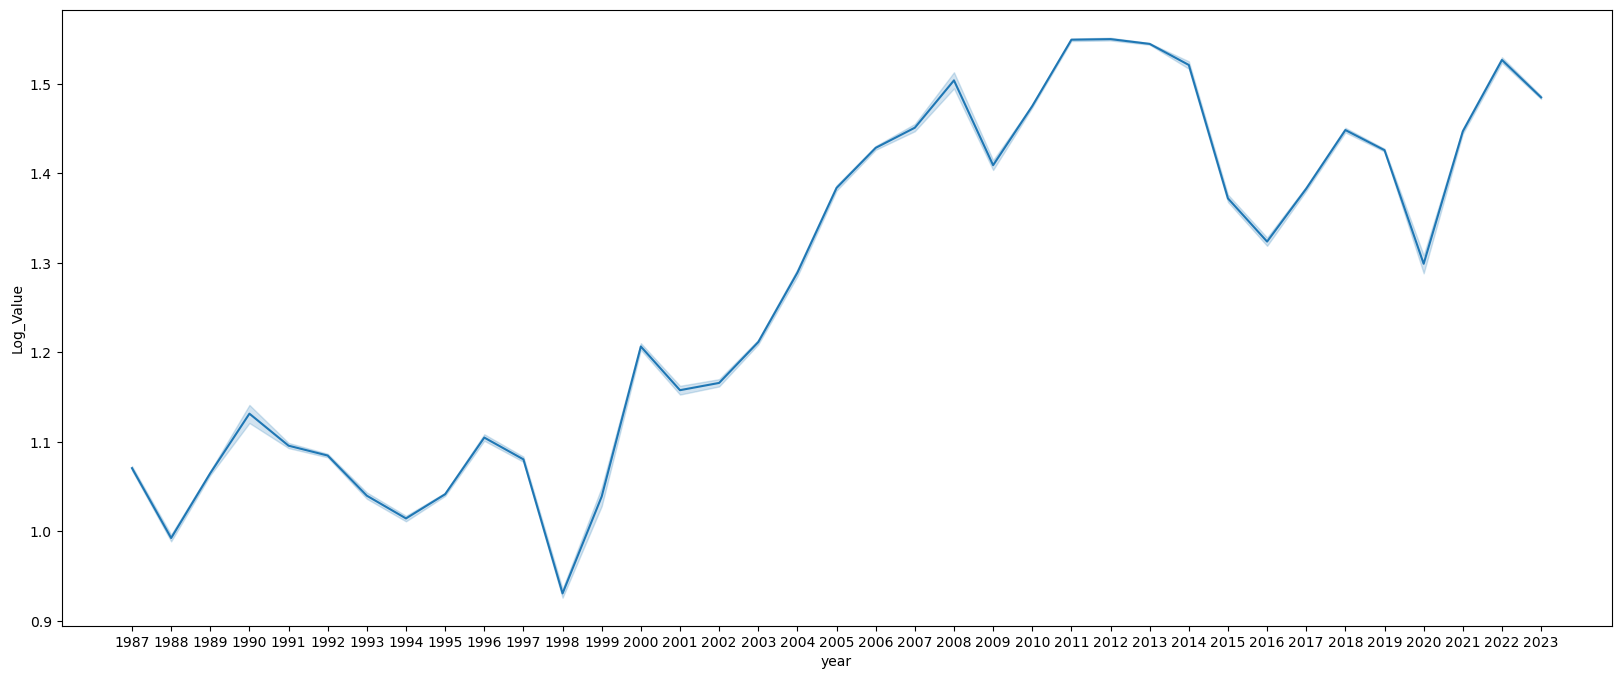

In [63]:
plt.figure(figsize=(20,8))
sns.lineplot(x="year",y="Log_Value",data = pp)

# linear regression model

In [64]:
import statsmodels.api as sm

In [65]:
# Fitting the linear regression model
linear_model = sm.OLS(train1['Log_Value'], sm.add_constant(train1['t'])).fit()

# Making predictions on the test set
predictions = linear_model.predict(sm.add_constant(test1['t']))

# Calculating RMSE
rmse = np.sqrt(np.mean((test1['Log_Value'] - predictions) ** 2))

In [66]:
rmse

0.2217766736687494

# Ordinary least-squares (OLS) models

In [67]:
#Linear Model

linear_model = smf.ols('Log_Value~t',data=train1).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test1['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test1['Log_Value'])-np.array(pred_linear))**2))
rmse_linear

0.2217766736687494

In [68]:
#Exponential

Exp = smf.ols('Log_Value~t',data=train1).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test1['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test1['Log_Value'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

3.666486466370522

In [69]:
#Quadratic 

quad = smf.ols('Log_Value ~ t + t_sq',data = train1).fit()
predquad = pd.Series(quad.predict(pd.DataFrame(test1[['t','t_sq']])))
rmsequad = np.sqrt(np.mean((np.array(test1['Log_Value'])-np.array(predquad))**2))
rmsequad

0.6211746738689568

In [70]:
#Additive seasonality 

add_sea = smf.ols('Log_Value~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train1).fit()
pred_add_sea = pd.Series(add_sea.predict(test1[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test1['Log_Value'])-np.array(pred_add_sea))**2))
rmse_add_sea

0.24001680594869057

In [71]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Log_Value~t+t_sq+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train1).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test1[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_sq']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test1['Log_Value'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

0.6198967055039998

In [72]:
#Multiplicative Seasonality

Mul_sea = smf.ols('Log_Value~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train1).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test1))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test1['Log_Value'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1.927333879385315

In [73]:
#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('Log_Value~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train1).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test1))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test1['Log_Value'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

3.6665678468136282

In [74]:
#Compareing the results 

rsme_data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmsequad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(rsme_data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
0,rmse_linear,0.221777
3,rmse_add_sea,0.240017
4,rmse_add_sea_quad,0.619897
2,rmse_quad,0.621175
5,rmse_Mult_sea,1.927334
1,rmse_Exp,3.666486
6,rmse_Mult_add_sea,3.666568


The best model for forecasting among the ones listed would generally be the one with the lowest RMSE value, as it signifies the model's predictive accuracy. In this case, the rmse_linear model has the lowest RMSE value of 0.221777, making it the most accurate among the models provided for the specific dataset and context it was evaluated on. Therefore, for forecasting purposes based on this data, the rmse_linear model would be considered the best choice.

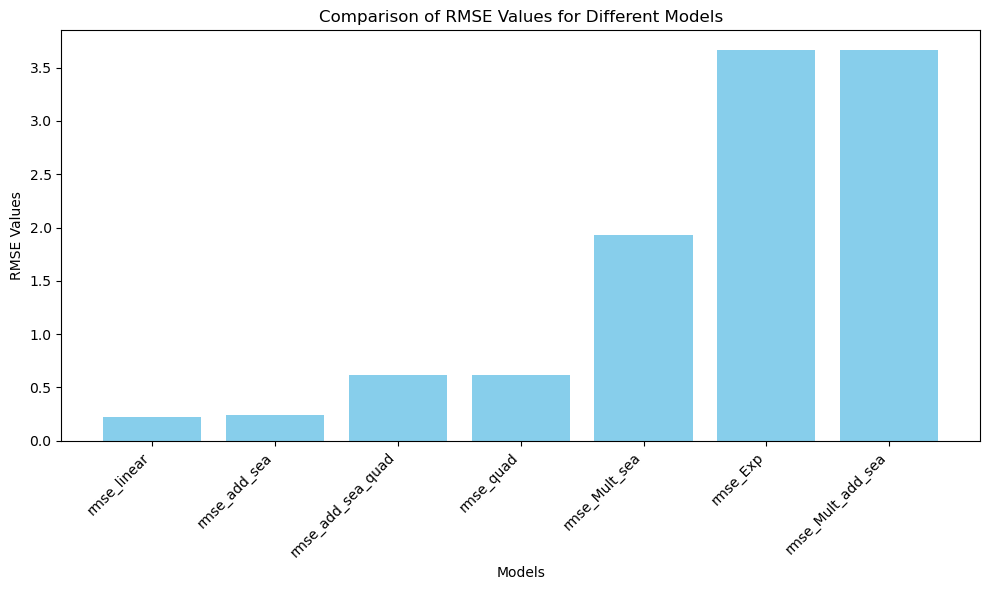

In [75]:
# Model names and corresponding RMSE values
models = [
    "rmse_linear",
    "rmse_add_sea",
    "rmse_add_sea_quad",
    "rmse_quad",
    "rmse_Mult_sea",
    "rmse_Exp",
    "rmse_Mult_add_sea"
]
rmse_values = [0.221777, 0.240017, 0.619897, 0.621175, 1.927334, 3.666486, 3.666568]

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color='skyblue')
plt.xlabel('Models')
plt.ylabel('RMSE Values')
plt.title('Comparison of RMSE Values for Different Models')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

plt.show()

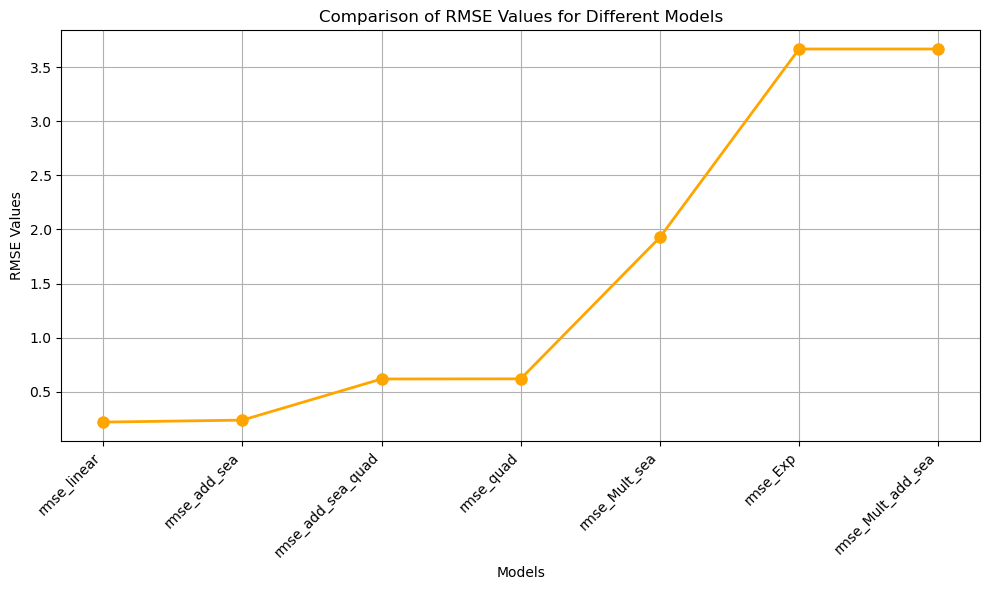

In [76]:
# Creating the line plot
plt.figure(figsize=(10, 6))
plt.plot(models, rmse_values, marker='o', linestyle='-', color='orange', linewidth=2, markersize=8)
plt.xlabel('Models')
plt.ylabel('RMSE Values')
plt.title('Comparison of RMSE Values for Different Models')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()

plt.show()

# Building Time series forecasting with ARIMA

In [77]:
# AutoRegressive Integrated Moving Average --> ARIMA

In [78]:
x = df['DCOILBRENTEU'].values

In [79]:
size = int(len(x) * 0.8)

In [80]:
train, test = x[0:size], x[size:len(x)]

In [81]:
model = ARIMA(train, order=(5,1,0))

In [82]:
result = model.fit()

In [83]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7618
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -11843.034
Date:                Wed, 20 Dec 2023   AIC                          23698.067
Time:                        10:01:05   BIC                          23739.696
Sample:                             0   HQIC                         23712.351
                               - 7618                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0728      0.006    -12.645      0.000      -0.084      -0.061
ar.L2         -0.0130      0.007     -1.880      0.060      -0.026       0.001
ar.L3         -0.0024      0.007     -0.352      0.7

In [84]:
# line plot of residuals
residuals = DataFrame(result.resid)

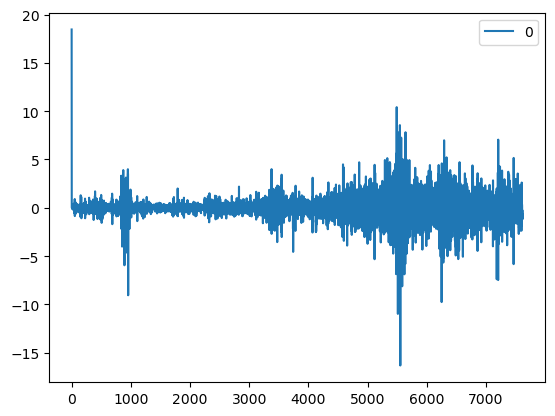

In [85]:
residuals.plot()
pyplot.show()

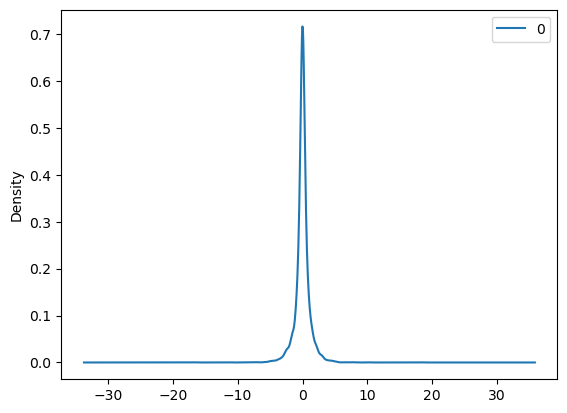

In [86]:
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

In [87]:
# summary stats of residuals
print(residuals.describe())

                 0
count  7618.000000
mean      0.005513
std       1.164871
min     -16.325609
25%      -0.358306
50%       0.011592
75%       0.388665
max      18.450000


Considering the mean close to zero and the median being similar, it indicates that the residuals are approximately normally distributed, which is a good characteristic for the residuals of a well-fitted model.

However, the presence of outliers (especially the maximum value) might warrant further investigation to understand if these extreme values are due to model limitations or actual rare occurrences in the data.

Overall, from the provided statistics, it seems that the ARIMA model is performing reasonably well in capturing the patterns in the data, though a detailed analysis of these residuals might be necessary to improve the model further or to identify any anomalies not accounted for in the forecasting process.

# Rolling Forecast ARIMA Model

In [88]:
history = [x for x in train]

In [89]:
predictions = list()

for i in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_hat = output[0]
    predictions.append(y_hat)
    obs = test[i]
    history.append(obs)
    print('predicted=%f, expected=%f' % (y_hat, obs))

predicted=40.219759, expected=40.000000
predicted=40.015693, expected=40.450000
predicted=40.412186, expected=41.330000
predicted=41.261242, expected=42.470000
predicted=42.377247, expected=43.240000
predicted=43.175258, expected=43.370000
predicted=43.356741, expected=42.190000
predicted=42.280601, expected=44.230000
predicted=44.098159, expected=45.120000
predicted=45.027360, expected=47.310000
predicted=47.116875, expected=48.270000
predicted=48.210528, expected=48.580000
predicted=48.537206, expected=49.460000
predicted=49.415915, expected=49.390000
predicted=49.380472, expected=48.100000
predicted=48.188427, expected=48.700000
predicted=48.683085, expected=47.560000
predicted=47.629466, expected=49.250000
predicted=49.122240, expected=49.660000
predicted=49.631432, expected=49.660000
predicted=49.629931, expected=47.940000
predicted=48.096842, expected=47.940000
predicted=47.953324, expected=45.050000
predicted=45.259366, expected=45.960000
predicted=45.903579, expected=46.720000


predicted=51.136804, expected=51.210000
predicted=51.198319, expected=51.760000
predicted=51.699927, expected=51.710000
predicted=51.740580, expected=52.780000
predicted=52.679909, expected=53.350000
predicted=53.306142, expected=53.190000
predicted=53.185072, expected=53.290000
predicted=53.297965, expected=52.250000
predicted=52.323816, expected=50.840000
predicted=50.945227, expected=52.250000
predicted=52.170979, expected=50.650000
predicted=50.741299, expected=49.400000
predicted=49.490676, expected=50.410000
predicted=50.389891, expected=48.460000
predicted=48.560727, expected=48.250000
predicted=48.278684, expected=48.110000
predicted=48.154878, expected=47.080000
predicted=47.120877, expected=46.300000
predicted=46.381798, expected=46.640000
predicted=46.627197, expected=47.180000
predicted=47.126485, expected=46.950000
predicted=46.957348, expected=45.470000
predicted=45.589325, expected=45.610000
predicted=45.621727, expected=45.700000
predicted=45.689427, expected=45.930000


predicted=67.885520, expected=67.590000
predicted=67.621628, expected=66.080000
predicted=66.190073, expected=64.230000
predicted=64.382477, expected=64.260000
predicted=64.269020, expected=65.780000
predicted=65.661149, expected=65.670000
predicted=65.648748, expected=65.090000
predicted=65.142914, expected=63.870000
predicted=63.983668, expected=65.190000
predicted=65.098008, expected=64.530000
predicted=64.559664, expected=64.200000
predicted=64.213317, expected=63.610000
predicted=63.686581, expected=63.670000
predicted=63.653071, expected=64.680000
predicted=64.610836, expected=64.820000
predicted=64.793253, expected=66.000000
predicted=65.916983, expected=68.150000
predicted=67.999163, expected=68.980000
predicted=68.888436, expected=69.030000
predicted=69.025825, expected=68.810000
predicted=68.842580, expected=68.630000
predicted=68.638533, expected=68.130000
predicted=68.161461, expected=69.020000
predicted=68.959905, expected=66.020000
predicted=66.223197, expected=72.110000


predicted=60.353235, expected=59.730000
predicted=59.725122, expected=59.940000
predicted=60.017598, expected=59.030000
predicted=59.050331, expected=58.560000
predicted=58.605209, expected=57.590000
predicted=57.675362, expected=55.260000
predicted=55.429199, expected=55.600000
predicted=55.598976, expected=52.840000
predicted=53.030069, expected=51.930000
predicted=51.994319, expected=57.360000
predicted=56.982920, expected=57.360000
predicted=57.250806, expected=57.360000
predicted=57.363026, expected=51.490000
predicted=52.018244, expected=50.570000
predicted=50.683989, expected=57.360000
predicted=56.884329, expected=59.410000
predicted=59.067627, expected=54.060000
predicted=54.382117, expected=53.230000
predicted=53.505294, expected=55.640000
predicted=55.536459, expected=57.100000
predicted=56.844316, expected=56.910000
predicted=56.863827, expected=59.460000
predicted=59.314953, expected=60.470000
predicted=60.371036, expected=59.240000
predicted=59.293238, expected=58.800000


predicted=64.666133, expected=64.130000
predicted=64.180917, expected=62.410000
predicted=62.571416, expected=62.080000
predicted=62.134724, expected=62.480000
predicted=62.463262, expected=60.990000
predicted=61.060519, expected=60.060000
predicted=60.162005, expected=57.920000
predicted=58.117016, expected=58.010000
predicted=58.030930, expected=59.130000
predicted=59.048778, expected=59.460000
predicted=59.370611, expected=58.140000
predicted=58.229543, expected=59.700000
predicted=59.637719, expected=59.080000
predicted=59.098335, expected=60.590000
predicted=60.456984, expected=58.810000
predicted=58.943946, expected=59.190000
predicted=59.175951, expected=59.300000
predicted=59.327608, expected=59.350000
predicted=59.300313, expected=59.960000
predicted=59.927363, expected=58.950000
predicted=59.009762, expected=60.500000
predicted=60.406657, expected=60.520000
predicted=60.500335, expected=61.710000
predicted=61.589016, expected=62.060000
predicted=62.039640, expected=60.390000


predicted=42.759332, expected=43.280000
predicted=43.266610, expected=43.670000
predicted=43.619167, expected=42.350000
predicted=42.426964, expected=43.270000
predicted=43.250912, expected=42.850000
predicted=42.864132, expected=42.970000
predicted=42.938561, expected=43.960000
predicted=43.919587, expected=43.710000
predicted=43.689200, expected=43.530000
predicted=43.552109, expected=43.300000
predicted=43.341028, expected=44.310000
predicted=44.235426, expected=43.980000
predicted=43.977176, expected=42.960000
predicted=43.031370, expected=43.290000
predicted=43.315195, expected=43.390000
predicted=43.363087, expected=43.110000
predicted=43.105708, expected=43.510000
predicted=43.503033, expected=42.980000
predicted=43.007129, expected=43.130000
predicted=43.124700, expected=43.760000
predicted=43.725149, expected=43.990000
predicted=43.945661, expected=44.920000
predicted=44.857946, expected=45.040000
predicted=45.023507, expected=44.070000
predicted=44.132974, expected=44.190000


predicted=66.566439, expected=65.340000
predicted=65.402309, expected=64.020000
predicted=64.136803, expected=65.070000
predicted=65.036296, expected=65.750000
predicted=65.653577, expected=65.500000
predicted=65.481406, expected=66.250000
predicted=66.227500, expected=67.080000
predicted=67.013714, expected=68.260000
predicted=68.150909, expected=67.730000
predicted=67.756683, expected=68.530000
predicted=68.498434, expected=68.910000
predicted=68.885241, expected=69.710000
predicted=69.630477, expected=68.620000
predicted=68.696994, expected=68.730000
predicted=68.750683, expected=68.610000
predicted=68.630289, expected=68.830000
predicted=68.792795, expected=69.620000
predicted=69.565473, expected=67.360000
predicted=67.499912, expected=69.240000
predicted=69.160727, expected=69.620000
predicted=69.565960, expected=69.010000
predicted=68.998487, expected=66.880000
predicted=67.090147, expected=65.180000
predicted=65.348743, expected=66.720000
predicted=66.636512, expected=68.590000


predicted=92.305411, expected=90.240000
predicted=90.352398, expected=91.430000
predicted=91.405050, expected=92.990000
predicted=92.879346, expected=96.860000
predicted=96.516617, expected=97.280000
predicted=97.181133, expected=96.070000
predicted=96.153301, expected=94.950000
predicted=95.119780, expected=96.370000
predicted=96.311811, expected=97.500000
predicted=97.374607, expected=101.660000
predicted=101.324734, expected=98.430000
predicted=98.576838, expected=97.440000
predicted=97.578663, expected=95.280000
predicted=95.544775, expected=96.180000
predicted=96.118434, expected=98.950000
predicted=98.733639, expected=98.730000
predicted=98.636927, expected=99.290000
predicted=99.249817, expected=101.290000
predicted=101.190918, expected=98.560000
predicted=98.696670, expected=103.080000
predicted=102.822976, expected=110.930000
predicted=110.347819, expected=118.940000
predicted=118.212224, expected=115.360000
predicted=115.429211, expected=123.860000
predicted=123.524943, expec

predicted=99.389451, expected=99.870000
predicted=99.722188, expected=96.850000
predicted=96.898280, expected=93.050000
predicted=93.486308, expected=94.250000
predicted=94.282983, expected=96.370000
predicted=96.182468, expected=93.590000
predicted=93.594621, expected=94.300000
predicted=94.431148, expected=92.610000
predicted=92.762638, expected=91.000000
predicted=91.008410, expected=88.930000
predicted=89.195971, expected=88.440000
predicted=88.494466, expected=88.650000
predicted=88.671496, expected=85.900000
predicted=86.016174, expected=85.590000
predicted=85.717465, expected=83.400000
predicted=83.584339, expected=83.500000
predicted=83.482049, expected=83.220000
predicted=83.306799, expected=85.610000
predicted=85.428778, expected=86.280000
predicted=86.216715, expected=86.540000
predicted=86.457319, expected=83.360000
predicted=83.588850, expected=79.920000
predicted=80.173925, expected=77.110000
predicted=77.410728, expected=76.020000
predicted=76.119367, expected=76.370000


predicted=85.870613, expected=85.440000
predicted=85.410711, expected=84.700000
predicted=84.802178, expected=83.940000
predicted=84.008760, expected=84.070000
predicted=84.069169, expected=85.420000
predicted=85.350106, expected=86.150000
predicted=86.066795, expected=86.370000
predicted=86.337886, expected=86.620000
predicted=86.623129, expected=87.290000
predicted=87.234916, expected=89.980000
predicted=89.811314, expected=90.420000
predicted=90.308816, expected=91.250000
predicted=91.169857, expected=91.790000
predicted=91.788921, expected=91.160000
predicted=91.115982, expected=91.850000
predicted=91.839467, expected=91.970000
predicted=91.948169, expected=93.580000
predicted=93.457859, expected=93.040000
predicted=93.048982, expected=95.200000
predicted=95.073768, expected=95.550000
predicted=95.515963, expected=95.950000
predicted=95.839829, expected=96.110000
predicted=96.154917, expected=94.560000
predicted=94.589264, expected=93.700000
predicted=93.789883, expected=93.990000


In [90]:
len(predictions)

1905

In [91]:
mse = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse)

Test MSE: 3.309


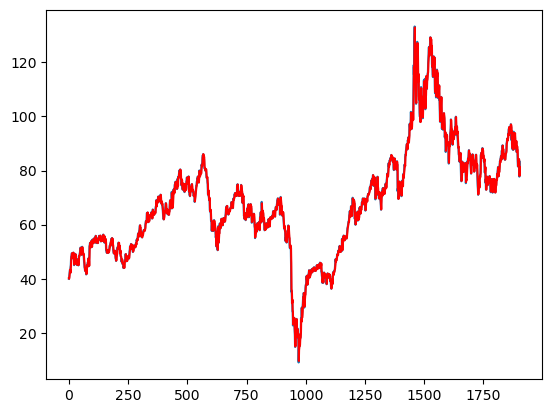

In [92]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale

# Neural Network for forecasting

# convolutional neural network(CNN)

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split

In [94]:
oil_data = pd.read_csv('DCOILBRENTEU.csv')

In [95]:
# Convert 'DATE' column to datetime
oil_data['DATE'] = pd.to_datetime(oil_data['DATE'])

# Convert 'DCOILBRENTEU' column to numeric
oil_data['DCOILBRENTEU'] = pd.to_numeric(oil_data['DCOILBRENTEU'], errors='coerce')

# Drop rows with missing values
oil_data.dropna(subset=['DCOILBRENTEU'], inplace=True)

# Create sequences for CNN
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

sequence_length = 10  # Define the sequence length/window size

# Create input sequences and corresponding target values
sequences = create_sequences(oil_data['DCOILBRENTEU'].values, sequence_length)
targets = oil_data['DCOILBRENTEU'].values[sequence_length:]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, shuffle=False)

# Reshape data for CNN input (assuming a single feature)
X_train = X_train.reshape((-1, sequence_length, 1))
X_test = X_test.reshape((-1, sequence_length, 1))

# Define the CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)  # Output layer for regression
])

In [96]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, mae, mse = model.evaluate(X_test, y_test)
print(f'Mean Squared Error: {mse}')

Epoch 1/100
232/232 [==============================] - 0s 919us/step - loss: 39.5803 - mae: 2.5723 - mse: 39.5803 - val_loss: 12.1327 - val_mae: 2.6175 - val_mse: 12.1327
Epoch 2/100
232/232 [==============================] - 0s 653us/step - loss: 4.5476 - mae: 1.3944 - mse: 4.5476 - val_loss: 10.0495 - val_mae: 2.3103 - val_mse: 10.0495
Epoch 3/100
232/232 [==============================] - 0s 637us/step - loss: 3.8490 - mae: 1.2797 - mse: 3.8490 - val_loss: 8.1341 - val_mae: 2.0195 - val_mse: 8.1341
Epoch 4/100
232/232 [==============================] - 0s 642us/step - loss: 3.2292 - mae: 1.1697 - mse: 3.2292 - val_loss: 6.9662 - val_mae: 1.9111 - val_mse: 6.9662
Epoch 5/100
232/232 [==============================] - 0s 644us/step - loss: 2.9372 - mae: 1.1164 - mse: 2.9372 - val_loss: 8.1872 - val_mae: 1.9959 - val_mse: 8.1872
Epoch 6/100
232/232 [==============================] - 0s 635us/step - loss: 2.3337 - mae: 0.9905 - mse: 2.3337 - val_loss: 5.5545 - val_mae: 1.7424 - val_mse:

Epoch 50/100
232/232 [==============================] - 0s 631us/step - loss: 1.7714 - mae: 0.8488 - mse: 1.7714 - val_loss: 4.2005 - val_mae: 1.5051 - val_mse: 4.2005
Epoch 51/100
232/232 [==============================] - 0s 631us/step - loss: 1.4974 - mae: 0.7808 - mse: 1.4974 - val_loss: 4.8897 - val_mae: 1.6793 - val_mse: 4.8897
Epoch 52/100
232/232 [==============================] - 0s 626us/step - loss: 1.5868 - mae: 0.8094 - mse: 1.5868 - val_loss: 4.1508 - val_mae: 1.3785 - val_mse: 4.1508
Epoch 53/100
232/232 [==============================] - 0s 626us/step - loss: 1.6139 - mae: 0.8084 - mse: 1.6139 - val_loss: 4.0936 - val_mae: 1.4657 - val_mse: 4.0936
Epoch 54/100
232/232 [==============================] - 0s 636us/step - loss: 1.7573 - mae: 0.8450 - mse: 1.7573 - val_loss: 3.7140 - val_mae: 1.3172 - val_mse: 3.7140
Epoch 55/100
232/232 [==============================] - 0s 621us/step - loss: 2.2289 - mae: 0.9464 - mse: 2.2289 - val_loss: 4.2444 - val_mae: 1.5303 - val_mse:

Epoch 99/100
232/232 [==============================] - 0s 637us/step - loss: 1.5243 - mae: 0.7933 - mse: 1.5243 - val_loss: 5.4577 - val_mae: 1.8145 - val_mse: 5.4577
Epoch 100/100
58/58 [==============================] - 0s 320us/step - loss: 3.8478 - mae: 1.4124 - mse: 3.8478
Mean Squared Error: 3.847815752029419


In [97]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Extract loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

Epoch 1/20
232/232 [==============================] - 0s 672us/step - loss: 1.4982 - mae: 0.7861 - mse: 1.4982 - val_loss: 3.6886 - val_mae: 1.3579 - val_mse: 3.6886
Epoch 2/20
232/232 [==============================] - 0s 634us/step - loss: 1.5444 - mae: 0.7972 - mse: 1.5444 - val_loss: 3.5804 - val_mae: 1.3102 - val_mse: 3.5804
Epoch 3/20
232/232 [==============================] - 0s 632us/step - loss: 1.4935 - mae: 0.7814 - mse: 1.4935 - val_loss: 3.9164 - val_mae: 1.4402 - val_mse: 3.9164
Epoch 4/20
232/232 [==============================] - 0s 628us/step - loss: 1.6481 - mae: 0.8226 - mse: 1.6481 - val_loss: 3.6210 - val_mae: 1.2962 - val_mse: 3.6210
Epoch 5/20
232/232 [==============================] - 0s 624us/step - loss: 1.5317 - mae: 0.7909 - mse: 1.5317 - val_loss: 3.6187 - val_mae: 1.3363 - val_mse: 3.6187
Epoch 6/20
232/232 [==============================] - 0s 643us/step - loss: 1.4337 - mae: 0.7625 - mse: 1.4337 - val_loss: 3.6111 - val_mae: 1.2970 - val_mse: 3.6111
Epoc

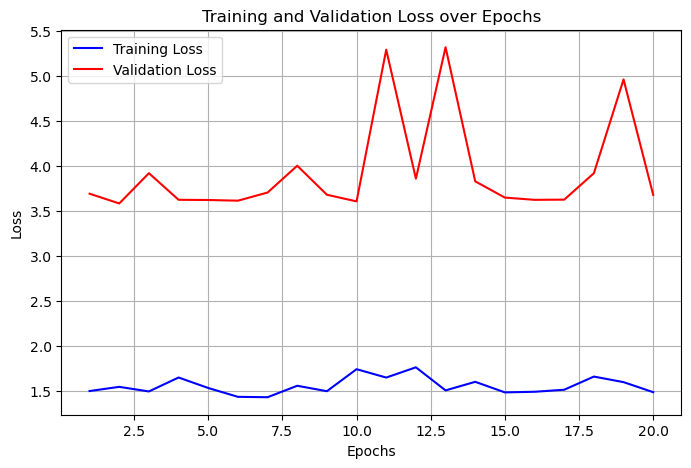

In [98]:
# Plotting loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [116]:
import os

# Get the current working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)


Current Directory: /Users/kishore


To summarize, monitoring both training and validation loss over epochs is essential. A decreasing training loss and a stable or decreasing validation loss imply that the model is learning and generalizing well. However, if the validation loss increases significantly while the training loss keeps decreasing, it might indicate overfitting, and further model adjustments or regularization techniques might be needed to improve generalization.

#  Long Short-Term Memory (LSTM)

In [101]:
from tensorflow.keras.layers import LSTM, Dense

In [102]:
# Split data into train and test sets
train_size = int(len(oil_data) * 0.8)  # 80% train, 20% test
train_data, test_data = oil_data['DCOILBRENTEU'][:train_size], oil_data['DCOILBRENTEU'][train_size:]

# Function to create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

sequence_length = 10  # Define the sequence length/window size

# Create input sequences and corresponding target values
train_sequences = create_sequences(train_data.values, sequence_length)
test_sequences = create_sequences(test_data.values, sequence_length)

# Split sequences into input (X) and target (y)
X_train, y_train = train_sequences[:, :-1], train_sequences[:, -1]
X_test, y_test = test_sequences[:, :-1], test_sequences[:, -1]

# Reshape input sequences for LSTM input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length-1, 1)),
    Dense(1)
])

In [103]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict on test data
predicted_values = model.predict(X_test)

Epoch 1/20
232/232 [==============================] - 1s 2ms/step - loss: 110.9149 - mae: 3.3228 - mse: 110.9149 - val_loss: 5.6837 - val_mae: 1.6859 - val_mse: 5.6837
Epoch 2/20
232/232 [==============================] - 0s 2ms/step - loss: 1.7875 - mae: 0.8939 - mse: 1.7875 - val_loss: 3.9302 - val_mae: 1.3743 - val_mse: 3.9302
Epoch 3/20
232/232 [==============================] - 0s 2ms/step - loss: 1.7054 - mae: 0.8765 - mse: 1.7054 - val_loss: 5.8458 - val_mae: 1.9015 - val_mse: 5.8458
Epoch 4/20
232/232 [==============================] - 0s 2ms/step - loss: 1.4967 - mae: 0.8109 - mse: 1.4967 - val_loss: 3.6597 - val_mae: 1.3226 - val_mse: 3.6597
Epoch 5/20
232/232 [==============================] - 0s 2ms/step - loss: 1.5833 - mae: 0.8351 - mse: 1.5833 - val_loss: 3.6574 - val_mae: 1.3114 - val_mse: 3.6574
Epoch 6/20
232/232 [==============================] - 0s 2ms/step - loss: 1.4898 - mae: 0.8009 - mse: 1.4898 - val_loss: 3.3165 - val_mae: 1.2144 - val_mse: 3.3165
Epoch 7/20
2

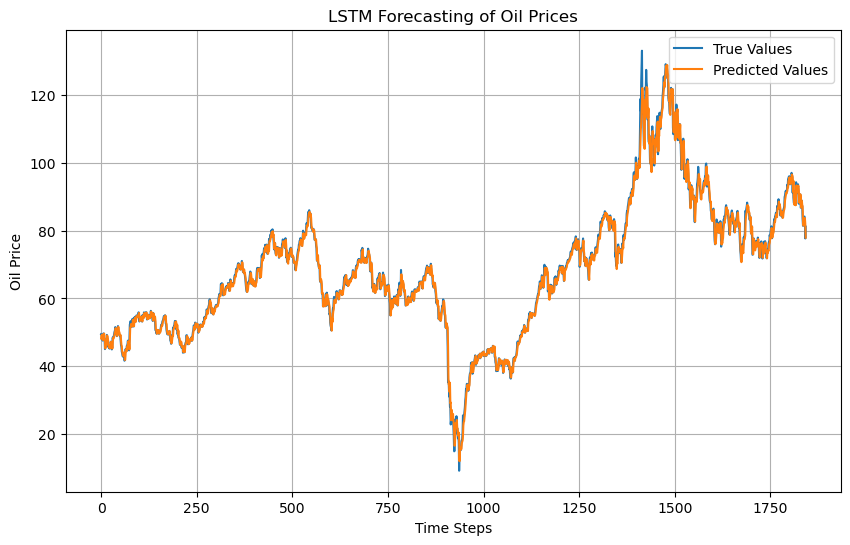

In [104]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Oil Price')
plt.title('LSTM Forecasting of Oil Prices')
plt.legend()
plt.grid(True)
plt.show()

In [105]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Extract loss values from the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

Epoch 1/20
232/232 [==============================] - 0s 2ms/step - loss: 1.3664 - mae: 0.7648 - mse: 1.3664 - val_loss: 4.5302 - val_mae: 1.4948 - val_mse: 4.5302
Epoch 2/20
232/232 [==============================] - 0s 2ms/step - loss: 1.3168 - mae: 0.7366 - mse: 1.3168 - val_loss: 3.3640 - val_mae: 1.2499 - val_mse: 3.3640
Epoch 3/20
232/232 [==============================] - 0s 2ms/step - loss: 1.2771 - mae: 0.7270 - mse: 1.2771 - val_loss: 3.4253 - val_mae: 1.2287 - val_mse: 3.4253
Epoch 4/20
232/232 [==============================] - 0s 2ms/step - loss: 1.3462 - mae: 0.7514 - mse: 1.3462 - val_loss: 3.2547 - val_mae: 1.2136 - val_mse: 3.2547
Epoch 5/20
232/232 [==============================] - 0s 2ms/step - loss: 1.4503 - mae: 0.7817 - mse: 1.4503 - val_loss: 3.6622 - val_mae: 1.3689 - val_mse: 3.6622
Epoch 6/20
232/232 [==============================] - 0s 2ms/step - loss: 1.5045 - mae: 0.7967 - mse: 1.5045 - val_loss: 3.3721 - val_mae: 1.2877 - val_mse: 3.3721
Epoch 7/20
232/2

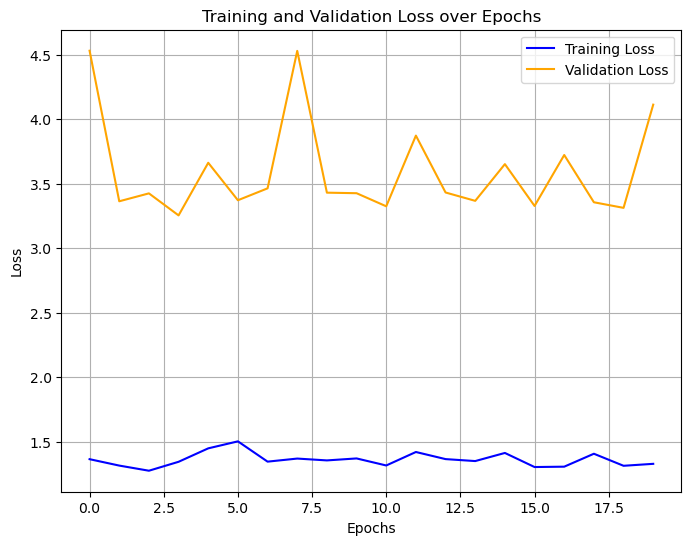

In [106]:
# Plotting the loss values over epochs
plt.figure(figsize=(8, 6))
plt.plot(training_loss, label='Training Loss', color='blue')
plt.plot(validation_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

The model's performance seems to improve on the training set, as indicated by the decreasing training loss. However, the gap between the training and validation losses suggests potential overfitting, where the model may be fitting too closely to the training data and struggling to generalize to new data.

In [107]:
df['DCOILBRENTEU']

date
1987-05-21    18.45
1987-05-22    18.55
1987-05-25    18.60
1987-05-26    18.63
1987-05-27    18.60
              ...  
2023-11-14    84.20
2023-11-15    82.40
2023-11-16    77.73
2023-11-17    81.22
2023-11-20    83.25
Name: DCOILBRENTEU, Length: 9523, dtype: float64

# Recurrent Neural Network (RNN)

In [108]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

# Load the data
# Replace this with your actual data loading method
# Assuming df is your pandas DataFrame with 'DATE' and 'DCOILBRENTEU' columns
# df = ...

# Dropping 'DATE' column as it's not needed for modeling
data = df['DCOILBRENTEU'].values.astype(float)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# Define window size for sequences
window_size = 10  # You can change this as needed

# Create sequences for RNN
sequences = []
labels = []
for i in range(len(data_scaled) - window_size):
    sequences.append(data_scaled[i:i + window_size])
    labels.append(data_scaled[i + window_size])

# Convert lists to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

# Build RNN model
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(window_size, 1)))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict using the model
predicted_values = model.predict(X_test)

# Inverse transform the predicted values to original scale
predicted_values_inv = scaler.inverse_transform(predicted_values)

# Print or use predicted_values_inv as needed

Epoch 1/20
238/238 [==============================] - 0s 873us/step - loss: 0.0039
Epoch 2/20
238/238 [==============================] - 0s 862us/step - loss: 2.3341e-04
Epoch 3/20
238/238 [==============================] - 0s 881us/step - loss: 1.8021e-04
Epoch 4/20
238/238 [==============================] - 0s 863us/step - loss: 1.7142e-04
Epoch 5/20
238/238 [==============================] - 0s 860us/step - loss: 1.4226e-04
Epoch 6/20
238/238 [==============================] - 0s 863us/step - loss: 1.4505e-04
Epoch 7/20
238/238 [==============================] - 0s 858us/step - loss: 1.2690e-04
Epoch 8/20
238/238 [==============================] - 0s 858us/step - loss: 1.1932e-04
Epoch 9/20
238/238 [==============================] - 0s 858us/step - loss: 1.2090e-04
Epoch 10/20
238/238 [==============================] - 0s 859us/step - loss: 1.1605e-04
Epoch 11/20
238/238 [==============================] - 0s 859us/step - loss: 1.0906e-04
Epoch 12/20
238/238 [========================

In [109]:
predicted_values_inv

array([[40.062847],
       [40.88268 ],
       [42.013382],
       ...,
       [82.430466],
       [78.299065],
       [80.19668 ]], dtype=float32)

RNN model using TensorFlow's Keras API. It preprocesses the data, builds the model, trains it, evaluates its performance, and makes predictions

#  Gated Recurrent Unit (GRU) 

In [110]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU

# Load the data
# Assuming df is your pandas DataFrame with 'DATE' and 'DCOILBRENTEU' columns
# df = ...

# Dropping 'DATE' column as it's not needed for modeling
data = df['DCOILBRENTEU'].values.astype(float)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# Define window size for sequences
window_size = 10  # You can change this as needed

# Create sequences for GRU
sequences = []
labels = []
for i in range(len(data_scaled) - window_size):
    sequences.append(data_scaled[i:i + window_size])
    labels.append(data_scaled[i + window_size])

# Convert lists to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

# Build GRU model
model = Sequential()
model.add(GRU(units=64, input_shape=(window_size, 1)))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict using the model
predicted_values = model.predict(X_test)

# Inverse transform the predicted values to original scale
predicted_values_inv_gru = scaler.inverse_transform(predicted_values)

# Print or use predicted_values_inv as needed


Epoch 1/20
238/238 [==============================] - 1s 2ms/step - loss: 0.0074
Epoch 2/20
238/238 [==============================] - 0s 2ms/step - loss: 1.6538e-04
Epoch 3/20
238/238 [==============================] - 0s 2ms/step - loss: 1.4985e-04
Epoch 4/20
238/238 [==============================] - 0s 2ms/step - loss: 1.3787e-04
Epoch 5/20
238/238 [==============================] - 0s 2ms/step - loss: 1.2743e-04
Epoch 6/20
238/238 [==============================] - 0s 2ms/step - loss: 1.2847e-04
Epoch 7/20
238/238 [==============================] - 0s 2ms/step - loss: 1.1533e-04
Epoch 8/20
238/238 [==============================] - 0s 2ms/step - loss: 1.0939e-04
Epoch 9/20
238/238 [==============================] - 0s 2ms/step - loss: 1.1258e-04
Epoch 10/20
238/238 [==============================] - 1s 2ms/step - loss: 1.0375e-04
Epoch 11/20
238/238 [==============================] - 0s 2ms/step - loss: 9.9645e-05
Epoch 12/20
238/238 [==============================] - 0s 2ms/step 

In [111]:
predicted_values_inv_gru

array([[40.397377],
       [41.107624],
       [42.17094 ],
       ...,
       [83.1662  ],
       [79.322365],
       [80.49874 ]], dtype=float32)

Epoch 1/20
238/238 [==============================] - 1s 2ms/step - loss: 0.0049
Epoch 2/20
238/238 [==============================] - 0s 2ms/step - loss: 1.3995e-04
Epoch 3/20
238/238 [==============================] - 0s 2ms/step - loss: 1.2924e-04
Epoch 4/20
238/238 [==============================] - 0s 2ms/step - loss: 1.2039e-04
Epoch 5/20
238/238 [==============================] - 0s 2ms/step - loss: 1.1271e-04
Epoch 6/20
238/238 [==============================] - 0s 2ms/step - loss: 1.0895e-04
Epoch 7/20
238/238 [==============================] - 0s 2ms/step - loss: 1.0061e-04
Epoch 8/20
238/238 [==============================] - 0s 2ms/step - loss: 1.0026e-04
Epoch 9/20
238/238 [==============================] - 0s 2ms/step - loss: 9.8326e-05
Epoch 10/20
238/238 [==============================] - 0s 2ms/step - loss: 9.4949e-05
Epoch 11/20
238/238 [==============================] - 0s 2ms/step - loss: 9.3004e-05
Epoch 12/20
238/238 [==============================] - 0s 2ms/step 

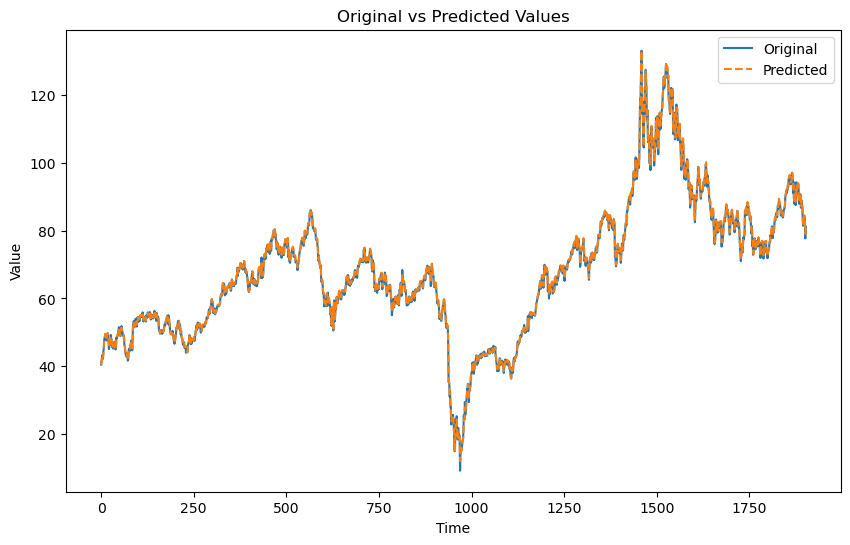

In [112]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
import matplotlib.pyplot as plt

# Load the data
# Assuming df is your pandas DataFrame with 'DATE' and 'DCOILBRENTEU' columns
# df = ...

# Dropping 'DATE' column as it's not needed for modeling
data = df['DCOILBRENTEU'].values.astype(float)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# Define window size for sequences
window_size = 10  # You can change this as needed

# Create sequences for GRU
sequences = []
labels = []
for i in range(len(data_scaled) - window_size):
    sequences.append(data_scaled[i:i + window_size])
    labels.append(data_scaled[i + window_size])

# Convert lists to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

# Build GRU model
model = Sequential()
model.add(GRU(units=64, input_shape=(window_size, 1)))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict using the model
predicted_values = model.predict(X_test)

# Inverse transform the predicted values to original scale
predicted_values_inv = scaler.inverse_transform(predicted_values)

# Prepare original and predicted values for plotting
original_values = data[-len(y_test) - 1:-1]  # Get original values for test set

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(original_values, label='Original')
plt.plot(predicted_values_inv, label='Predicted', linestyle='dashed')

plt.title('Original vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
